In [11]:

!rm -rf /content/spark*
!rm -f spark-3.5.1-bin-hadoop3.tgz

# Instalar Java
!apt-get update -qq
!apt-get install -y openjdk-11-jdk-headless -qq


!curl -O https://archive.apache.org/dist/spark/spark-3.5.1/spark-3.5.1-bin-hadoop3.tgz

# Verificar que el archivo se descargó
!ls -l spark-3.5.1-bin-hadoop3.tgz

# Extraer y verificar
!tar xf spark-3.5.1-bin-hadoop3.tgz
!ls -l /content/spark-3.5.1-bin-hadoop3

# Instalar pyspark
!pip install -q pyspark==3.5.1 findspark

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  381M  100  381M    0     0   409k      0  0:15:54  0:15:54 --:--:--  342k
-rw-r--r-- 1 root root 400446614 Nov  4 18:32 spark-3.5.1-bin-hadoop3.tgz
total 156
drwxr-xr-x 2 1000 1000  4096 Feb 15  2024 bin
drwxr-xr-x 2 1000 1000  4096 Feb 15  2024 conf
drwxr-xr-x 6 1000 1000  4096 Feb 15  2024 data
drwxr-xr-x 4 1000 1000  4096 Feb 15  2024 examples
drwxr-xr-x 2 1000 1000 20480 Feb 15  2024 jars
drwxr-xr-x 4 1000 1000  4096 Feb 15  2024 kubernetes
-rw-r--r-- 1 1000 1000 22916 Feb 15  2024 LICENSE
drwxr-xr-x 2 1000 1000  4096 Feb 15  2024 licenses
-rw-r--r-- 1 1000 1000 57842 Feb 15  2024 NOTICE
drwxr-xr-x 9 1000 1000  4096 Feb 15  2024 python


In [12]:
import os
import findspark

# Verificar que los directorios existen
!ls -l /content/spark-3.5.1-bin-hadoop3/bin/
!ls -l /content/spark-3.5.1-bin-hadoop3/python/

# Configurar variables de entorno
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.1-bin-hadoop3"

# Verificar que las variables están configuradas
print("JAVA_HOME:", os.environ.get("JAVA_HOME"))
print("SPARK_HOME:", os.environ.get("SPARK_HOME"))

# Inicializar Spark
findspark.init()

total 120
-rwxr-xr-x 1 1000 1000  1089 Feb 15  2024 beeline
-rw-r--r-- 1 1000 1000  1064 Feb 15  2024 beeline.cmd
-rwxr-xr-x 1 1000 1000 10987 Feb 15  2024 docker-image-tool.sh
-rwxr-xr-x 1 1000 1000  1935 Feb 15  2024 find-spark-home
-rw-r--r-- 1 1000 1000  2685 Feb 15  2024 find-spark-home.cmd
-rw-r--r-- 1 1000 1000  2337 Feb 15  2024 load-spark-env.cmd
-rw-r--r-- 1 1000 1000  2678 Feb 15  2024 load-spark-env.sh
-rwxr-xr-x 1 1000 1000  2636 Feb 15  2024 pyspark
-rw-r--r-- 1 1000 1000  1542 Feb 15  2024 pyspark2.cmd
-rw-r--r-- 1 1000 1000  1170 Feb 15  2024 pyspark.cmd
-rwxr-xr-x 1 1000 1000  1030 Feb 15  2024 run-example
-rw-r--r-- 1 1000 1000  1223 Feb 15  2024 run-example.cmd
-rwxr-xr-x 1 1000 1000  3561 Feb 15  2024 spark-class
-rwxr-xr-x 1 1000 1000  2891 Feb 15  2024 spark-class2.cmd
-rw-r--r-- 1 1000 1000  1180 Feb 15  2024 spark-class.cmd
-rwxr-xr-x 1 1000 1000  1154 Feb 15  2024 spark-connect-shell
-rwxr-xr-x 1 1000 1000  1047 Feb 15  2024 sparkR
-rw-r--r-- 1 1000 1000  1097 

In [13]:
from pyspark.sql import SparkSession

# Crear sesión de Spark
spark = SparkSession.builder \
    .appName("Análisis_PY") \
    .master('local[*]') \
    .getOrCreate()

print("Versión de Spark:", spark.version)


Versión de Spark: 3.5.1


In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.functions import col,when,from_unixtime, to_timestamp
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator


df = spark.read.csv("/content/m15.csv",header=True, inferSchema=True)



df.show(5)

+---+-----+-------------+-----------+-----------+----------+------------+-------------+------------------+------------------+------------------+------------------+------------------+-----------+-----------+----------+------------+-------------+--------------------+--------------------+--------------------+--------------------+-------------------+-----------+-----------+----------+------------+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------+-----------+----------+------------+-------------+--------------------+--------------------+--------------------+--------------------+-------------------+-----------+-----------+----------+------------+-------------+--------------------+--------------------+--------------------+--------------------+-------------------+-----------+-----------+----------+------------+-------------+-------------------+--------------------+--------------------+--------------------+--------

In [15]:
#Normalizar la columna de timestamp en un formato de fecha
df = df.withColumn('timestamp', to_timestamp(from_unixtime(col('timestamp') / 1000)))
#Normalizar columnas a usar y castearlos a double
col_cast = ['xauusd_open', 'xauusd_high', 'xauusd_low', 'xauusd_close']
for c in col_cast:
  df = df.withColumn(c, col(c).cast('double'))
#Quitar datos faltantes de las columnas
df = df.dropna(subset=['xauusd_open', 'xauusd_high', 'xauusd_low','xauusd_close'])
#Se utiliza el assembler para peparar todo en un solo vector "features"
assembler = VectorAssembler(inputCols=['xauusd_open', 'xauusd_high', 'xauusd_low'], outputCol='features')
#Se agarran las columnas para el modelo, "features" y "xauusd_close"
data = assembler.transform(df).select('features', 'xauusd_close')
data.show(5)

+--------------------+------------+
|            features|xauusd_close|
+--------------------+------------+
|[422.433,423.611,...|     423.311|
|[423.022,423.911,...|     423.658|
|[423.563,423.851,...|     422.745|
|[422.558,423.377,...|     423.122|
|[423.203,423.524,...|     422.695|
+--------------------+------------+
only showing top 5 rows



In [16]:
#Se divide el data set en 80 % 20%
train, test = data.randomSplit([0.8, 0.2], seed=42)
#Se meten las columnas al modelo
lr = LinearRegression(featuresCol='features', labelCol='xauusd_close')
#Se ajusta el modelo
model = lr.fit(train)
print('Coeficientes:', model.coefficients)
print('Intercepto:', model.intercept)

Coeficientes: [-0.5122815863781426,0.7764900251352252,0.7357366082763108]
Intercepto: 0.06743790258262147


In [17]:
#Hace la prediccioón
pred = model.transform(test)
pred.select('xauusd_close', 'prediction').show(10)

#Crear los evaluadores para el modelo que es el coeficiente de determianción y mean square error
evaluator_rmse = RegressionEvaluator(labelCol='xauusd_close', predictionCol='prediction', metricName='rmse')
evaluator_r2 = RegressionEvaluator(labelCol='xauusd_close', predictionCol='prediction', metricName='r2')
rmse = evaluator_rmse.evaluate(pred)
r2 = evaluator_r2.evaluate(pred)

print(f'RMSE en test: {rmse:.4f}')
print(f'R2 en test: {r2:.4f}')

+------------+------------------+
|xauusd_close|        prediction|
+------------+------------------+
|     371.003| 370.9827835147004|
|     372.044|372.07913092886315|
|     372.294|372.70021246168284|
|     372.436| 372.1238927628719|
|     372.036|372.52388934957287|
|      373.15| 373.0350238114834|
|     373.506|373.21427865132534|
|     373.599|373.43734015131616|
|     373.783|  373.832856839858|
|     374.208|373.77329857779483|
+------------+------------------+
only showing top 10 rows

RMSE en test: 0.5726
R2 en test: 1.0000


Cross Validation K fold

In [18]:
#Se crea el cross validation con los parámetros fijos, y un múmero de iteraciones de 3
paramGrid= ParamGridBuilder().build()
crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator_rmse,
                          numFolds=3,
                          seed = 42)
#Se entrena el modelo con crossvalidation y la partición de train
cvModel = crossval.fit(train)
#Se hace la predcción ahora con el test
pred = cvModel.transform(test)
#Se evalua el modelo con el cross validation
rmse = evaluator_rmse.evaluate(pred)
r2 = RegressionEvaluator(labelCol='xauusd_close', predictionCol='prediction', metricName='r2').evaluate(pred)

print(f'RMSE en test: {rmse:.4f}')
print(f'R2 en test: {r2:.4f}')
#Se escoje el mejor modelo  de acuerdo a los parámetros que arrojo el modelo con test
bestModel = cvModel.bestModel
print('Mejor regParam:', bestModel._java_obj.getRegParam())
print('Mejor elasticNetParam:', bestModel._java_obj.getElasticNetParam())
#Se puede observar que con el cross validation y sin el cross validation los mejores parámetroa y los resultados son los mismos, esto quiere decir que desde un principio el modelo ya arrojaba su mejor versión


RMSE en test: 0.5726
R2 en test: 1.0000
Mejor regParam: 0.0
Mejor elasticNetParam: 0.0


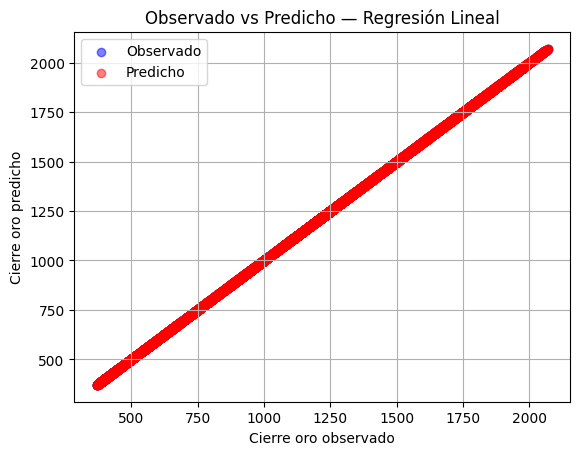

In [19]:
pred_pd = pred.select('xauusd_close', 'prediction').toPandas()
plt.scatter(pred_pd['xauusd_close'], pred_pd['xauusd_close'], alpha=0.5, color='blue', label='Observado')
plt.scatter(pred_pd['xauusd_close'], pred_pd['prediction'], alpha=0.5, color='red', label='Predicho')
plt.xlabel('Cierre oro observado')
plt.ylabel('Cierre oro predicho')
plt.title('Observado vs Predicho — Regresión Lineal')
plt.grid(True)
plt.legend()
plt.show()

RMSE en train: 0.5802
R2 en train: 1.0000


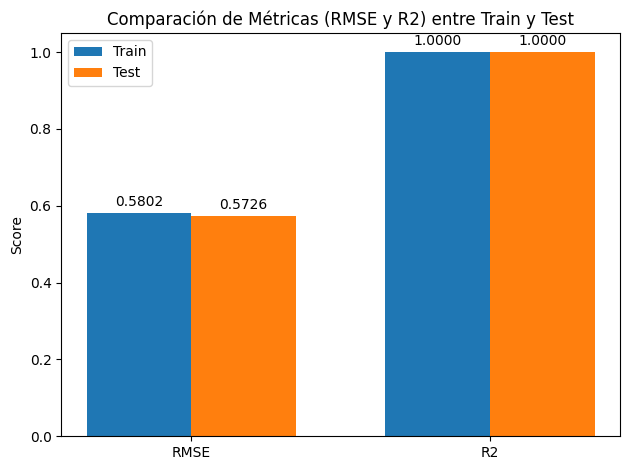

In [21]:
#Agarramos el R^2 y MSE que ya tuvimos anteriormente
train_pred = model.transform(train)

rmse_train = evaluator_rmse.evaluate(train_pred)
r2_train = evaluator_r2.evaluate(train_pred)

print(f'RMSE en train: {rmse_train:.4f}')
print(f'R2 en train: {r2_train:.4f}')

#Ploteamos las métricas
metrics = ['RMSE', 'R2']
train_values = [rmse_train, r2_train]
test_values = [rmse, r2]

x = range(len(metrics))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar([i - width/2 for i in x], train_values, width, label='Train')
rects2 = ax.bar([i + width/2 for i in x], test_values, width, label='Test')

#Se hace una funcion para que ls barras de las gráficas tengan su descripción y se titulan los labels
ax.set_ylabel('Score')
ax.set_title('Comparación de Métricas (RMSE y R2) entre Train y Test')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
fig.tight_layout()
plt.show()

Código para limpiar el data set para tableau

In [20]:
# Seleccioné las columnas que trabajaré en tableau
tableau_df = df.select(
    'timestamp',
    'xauusd_open',
    'xauusd_high',
    'xauusd_low',
    'xauusd_close',
    'xauusd_volume',
    'xauusd_tail',
    'xauusd_head',
    'xauusd_body',
    'xauusd_abs_body',
    'xauusd_movement'
)

tableau_df.show(5)

#Convertí el dateframe de Spark a dataframe de Pandas para exportación más fácil
tableau_pd = tableau_df.toPandas()

# Guardo el csv
tableau_pd.to_csv('xauusd_tableau.csv', index=False)
print('Se creó y guardó el archivo')

+-------------------+-----------+-----------+----------+------------+-------------+------------------+------------------+------------------+------------------+------------------+
|          timestamp|xauusd_open|xauusd_high|xauusd_low|xauusd_close|xauusd_volume|       xauusd_tail|       xauusd_head|       xauusd_body|   xauusd_abs_body|   xauusd_movement|
+-------------------+-----------+-----------+----------+------------+-------------+------------------+------------------+------------------+------------------+------------------+
|2004-01-05 17:30:00|    422.433|    423.611|   422.433|     423.311|       0.2311|               0.0|30.000000000001137|-87.79999999999859| 87.79999999999859|117.79999999999973|
|2004-01-05 17:45:00|    423.022|    423.911|   422.488|     423.658|       0.1958| 53.39999999999918| 25.29999999999859|-63.60000000000241| 63.60000000000241|142.30000000000018|
|2004-01-05 18:00:00|    423.563|    423.851|   422.192|     422.745|       0.1847| 55.29999999999973| 28